### Setup

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import subprocess
import astropy.table
import astropy.io.fits as fits
import numpy as np
from copy import deepcopy
import random
from astropy.table import Table
import os 
import matplotlib.pyplot as plt 
import fitsio 

In [3]:
#directories that would be using 
locations = dict(
WLD = '/Users/Ismael/code/lensing/WeakLensingDeblending/',
SMFF = '/Users/Ismael/code/lensing/SMFF/',
aegis = '/Users/Ismael/aegis/data/',
SEx = '/Users/Ismael/aegis/data/sextractor_runs/',
aegis_slac = '/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/data',
temp_data = '/Users/Ismael/temp_data'
)
os.chdir(locations['WLD']) #set this to interested directory 

In [4]:
def mad(arr):
    """ Median Absolute Deviation: a "Robust" version of standard deviation.
        Indices variabililty of the sample.
        https://en.wikipedia.org/wiki/Median_absolute_deviation 
    """
    arr = np.ma.array(arr).compressed() # should be faster to not use masked arrays.
    med = np.median(arr)
    return np.median(np.abs(arr - med))

### prepare input 

In [5]:
#files 
#g1,g2=0,0
#g1,g2=.01,.01
#g1,g2=-.01,-.01
#g1,g2=.02,.02
#g1,g2=-.02,-.02
files = dict(
final_fits1 = 'Users/Ismael/aegis/data/fits_files/final_fits1.fits', 
final_fits2 = 'Users/Ismael/aegis/data/fits_files/final_fits2.fits', 
final_fits3 = 'Users/Ismael/aegis/data/fits_files/final_fits3.fits', 
final_fits4 = 'Users/Ismael/aegis/data/fits_files/final_fits4.fits', 
final_fits5 = 'Users/Ismael/aegis/data/fits_files/final_fits5.fits', 
)

files_temps = dict() 
for f in files: 
    l = files[f].split("/")
    temp_file = '{0}{1}'.format('/Users/Ismael/temp_data/',l[-1])
    files_temps[f] = temp_file

    
files_slac = dict()
for f in files: 
    l = files[f].split("/")
    index_data = l.index("aegis")
    str_slac = "/".join(l[index_data:])
    slac_file = '{0}{1}'.format('/nfs/slac/g/ki/ki19/deuce/AEGIS/ismael/',str_slac)
    files_slac[f] = slac_file

### Samples 

In [6]:
#some interesting subsets of the simulation
iso_gal = lambda cat: cat[cat['purity'] > .98] #isolated galaxies
grp_gal = lambda cat: cat[cat['purity'] <= .98] #galaxies in a group of 2 or more. 

#'good' galaxies satisfy the reasonable criteria below.
good = lambda cat: cat[(cat['snr_grpf'] > 6) & (cat['sigma_m'] > .2)]

#gold sample galaxies 
gold = lambda cat: cat[(cat['ab_mag'] < 25.3)] 

#ambiguity of blends. 
ambig = lambda cat: cat[cat['ambig_blend'] == True ]
not_ambig = lambda cat: cat[cat['ambig_blend'] == False ]
detected = lambda cat: cat[cat['match'] != -1]
not_detected = lambda cat: cat[cat['match'] == -1]

#cuts 
cut_biasiso = lambda cat,bias_cut: cat[(np.absolute(cat['bias_g1']) < bias_cut) & (np.absolute(cat['bias_g2']) < bias_cut)]
cut_biasgrp = lambda cat,bias_cut: cat[(np.absolute(cat['bias_g1_grp']) < bias_cut) & (np.absolute(cat['bias_g2_grp']) < bias_cut)]
down_cut = lambda cat,param,cut: cat[cat[param] < cut]
up_cut = lambda cat,param,cut: cat[cat[param] > cut]
abs_cut = lambda cat,param,cut,point=0: cat[np.absolute(cat[param] - point) < cut]
unphysical_iso = lambda cat: cat[(np.absolute(cat['bias_g1']) > 1.) | (abs(cat['bias_g2']) > 1.)]
unphysical_grp = lambda cat: cat[(np.absolute(cat['bias_g1_grp']) > 1.) | (np.absolute(cat['bias_g2_grp']) > 1.)]

#more specific 
detc_and_notambig = lambda cat: cat[(cat['ambig_blend'] == False) & (cat['match'] != -1)]
notdetc_and_notambig = lambda cat: cat[(cat['ambig_blend'] == False) & (cat['match'] == -1)]
detc_and_ambig = lambda cat: cat[(cat['ambig_blend'] == True) & (cat['match'] != -1)]
notdetc_and_ambig = lambda cat: cat[(cat['ambig_blend'] == True) & (cat['match'] == -1)]
best = detc_and_notambig

### Read 

In [7]:
f = fits.open(files_temps['final_fits1'])
catalogue = Table.read(f,hdu=1)

In [8]:
float(len(good(catalogue)))/len(catalogue)

0.18503799382389866

### are dx,dy values correct ?

In [17]:
catalogue[catalogue['sigma_m']>1]

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit,bias_f,bias_s,bias_g1,bias_g2,bias_x,bias_y,bias_f_grp,bias_s_grp,bias_g1_grp,bias_g2_grp,bias_x_grp,bias_y_grp,match,ambig_blend
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bool
402700062465,402700062465,7,0,0,49,122,4498,4564,0.687221,0.312779,-1782.8,-893.785,0.36838,20.2339,0.593647,9.07282e+06,1.20829,1.30251,0.0727192,0.263928,1.6002,0.912359,0.65097,1.37422,0.998596,742.368,702.543,702.543,329.272,327.581,0.00404432,0.00230901,0.00257738,0.00406705,0.00231486,0.00258133,nan,nan,nan,0.0,2.98023e-09,74.5709,2.72053e-06,1.01961e-06,3.69675e-06,-8.64013e-12,-3.65757e-11,-27.2646,-1.29671e-05,3.50428e-06,-8.04401e-07,2.19982e-07,4.7818e-07,-1,False
402701940434,402700062465,7,2,1,60,92,4477,4506,1.0,0.0,-1784.69,-901.53,0.52408,24.3246,0.423708,209635.0,1.12653,1.13483,0.0484384,-0.07064,1.22753,1.03384,-0.484864,1.28595,0.968339,16.4713,16.4541,16.454,9.59855,9.58763,0.105833,0.0873715,0.087852,0.105969,0.0874952,0.0878638,nan,nan,nan,0.0,2.98023e-09,1847.12,-0.00435455,0.000904183,-0.00132002,-5.81307e-07,1.17344e-06,1776.64,-0.00473254,0.00087804,-0.0011158,7.15835e-05,-6.2017e-05,-1,False
402712776059,402701806617,9,8,1,35,46,4493,4505,1.0,0.0,-1791.83,-900.18,0.212148,27.1781,0.148973,15137.5,1.2135,1.22054,-0.0279766,-0.0707454,1.30961,1.12444,-0.973689,1.36248,0.0841719,1.00691,1.00683,1.00608,0.264541,0.189744,3.47336,2.35832,2.34332,3.69362,2.73616,2.92286,nan,nan,nan,0.0,0.0,284674.0,7.8237,-0.230253,-0.742554,-0.095792,-0.130572,294504.0,0.870921,0.698346,-6.91201,-0.351497,-0.7893,-1,False
402700795956,402700155390,46,6,1,4431,4473,2438,2468,0.990091,0.00990878,-909.473,-1309.22,1.05311,23.182,0.386312,600499.0,1.02115,1.07685,0.192018,0.127251,1.2911,0.807641,0.292627,1.20578,0.952966,51.7591,51.5751,51.5717,30.5764,23.0169,0.0353179,0.0287094,0.0275116,0.0423924,0.0379276,0.0352328,nan,nan,nan,0.0,2.98023e-09,487.693,-0.000622168,0.000415755,0.000275716,9.85651e-09,6.68346e-08,-8055.16,-0.00383994,0.00099932,0.00285371,-0.0118826,0.00422394,-1,False
402700686439,402700155390,46,8,1,4469,4516,2454,2488,0.830563,0.169437,-901.438,-1305.73,1.11132,23.1983,0.704124,591505.0,1.11572,1.26087,0.192145,0.291171,1.60582,0.775192,0.493745,1.30533,0.204311,48.8374,48.6671,48.2655,26.0266,8.06058,0.0454638,0.0296878,0.0325572,0.0881847,0.0757556,0.0616193,nan,nan,nan,0.0,2.98023e-09,692.078,-0.000457306,0.000515818,0.000781271,2.37604e-09,-1.67035e-08,23375.1,-0.00989925,-0.00336717,-0.00193093,0.0250459,0.0127838,-1,False
402700478666,402700155390,46,4,0,4489,4529,2385,2431,1.0,0.0,-898.148,-1318.36,0.257722,22.6016,0.249836,1.02485e+06,1.20596,1.22065,-0.0876962,0.0664623,1.34683,1.07981,1.24654,1.35719,0.999475,76.4011,76.0523,76.0523,45.2999,45.2559,0.0219778,0.0183223,0.0182008,0.0220039,0.0183295,0.0182167,nan,nan,nan,0.0,2.98023e-09,354.165,-0.00024231,-7.21472e-05,5.46572e-05,-8.57365e-09,-1.0882e-08,156.654,-0.000452579,2.90322e-05,0.000125151,2.0947e-05,-2.64795e-05,-1,False
402702366957,402700087044,39,14,1,4103,4133,1893,1936,0.89183,0.10817,-976.276,-1416.96,1.67964,24.5066,1.20741,177273.0,1.42106,1.77377,-0.212527,-0.415901,2.35774,0.856507,-1.0216,1.60376,0.167879,12.5103,12.5007,12.4799,6.50738,4.20684,0.171749,0.0968147,0.123425,0.21841,0.122705,0.146759,nan,nan,nan,0.0,0.0,3960.26,-0.00158117,-0.00727399,-0.0142421,9.05143e-10,-1.48729e-06,9298.44,0.0068862,0.0137503,-0.0157539

In [20]:
#transform to ds9 coordinates. 
def getds9pos(dx,dy):
    return (dx/.2 + 9000,dy/.2 + 9000)



In [21]:
getds9pos(-958.442,-1366.43	)

(4207.79, 2167.8500000000004)

### Show the rare_objs 

percentage of objects with snr_grpf greater than 10: 0.927


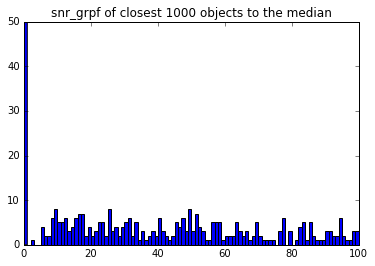

In [35]:
cat = best(gold(cat))
param = 'bias_g1_grp'
med = np.median(cat[param])
n = 1000.
p = (n/len(cat))*100.
w = np.percentile(np.absolute(cat[param] - med),p)
cat_cut = cat[ (cat[param] < med + w) &  (cat[param] > med - w)]
plt.hist(cat_cut['snr_grpf'],range=(0,100),bins=100)
plt.title('snr_grpf of closest {0:0g} objects to the median'.format(n))
print 'percentage of objects with snr_grpf greater than 10:', float(len(cat_cut[cat_cut['snr_grpf']>10]))/len(cat_cut)

In [36]:
rare_objs = abs_cut(cat_cut,'snr_grpf',2)

In [37]:
rare_objs

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit,bias_f,bias_s,bias_g1,bias_g2,bias_x,bias_y,bias_f_grp,bias_s_grp,bias_g1_grp,bias_g2_grp,bias_x_grp,bias_y_grp,match,ambig_blend
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bool
402702901907,402700083686,14,3,1,1795,1812,2604,2620,1.0,0.0,-1439.25,-377.465,0.487389,24.7755,0.441755,138384.0,0.3261,0.335823,0.0913279,0.14501,0.387721,0.274273,0.504376,0.701148,0.973771,22.9271,22.8626,0.0,15.0085,0.0,0.139894,0.122503,0.127106,inf,inf,inf,nan,nan,nan,0.0,0.0,679.005,-0.0224086,0.00679516,0.0107998,-6.5909e-07,-9.42657e-07,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,102121,False
402700083686,402700083686,14,0,1,1726,1811,2619,2661,0.81401,0.18599,-1446.21,-371.929,0.765379,20.8211,0.8915,5.28268e+06,1.07661,1.57026,0.550617,-0.239352,2.15453,0.537975,-0.205028,1.35423,0.994833,476.363,459.958,0.0,257.502,0.0,0.00547794,0.00417483,0.00260081,inf,inf,inf,nan,nan,nan,0.0,0.0,66.7773,-1.2286e-05,2.33172e-05,-1.01458e-05,1.91149e-11,3.07506e-11,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,102164,False
402701456831,402700005120,190,31,1,383,406,2698,2715,0.993656,0.00634408,-1721.06,-358.557,3.22464,23.9957,0.00880051,283793.0,0.380344,0.466222,0.365305,-0.259558,0.616114,0.234797,-0.308877,0.75841,0.881101,44.0857,43.8616,0.0,28.6463,0.0,0.0872943,0.0719142,0.0604243,inf,inf,inf,nan,nan,nan,0.0,0.0,371.235,-0.00877109,0.00845146,-0.00600561,-7.55705e-08,4.66139e-08,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,103492,False
402701021226,402700005120,190,20,1,364,384,2685,2707,0.831083,0.168917,-1725.09,-360.737,1.21783,23.5662,0.470728,421512.0,0.267078,0.381857,-0.332291,0.482284,0.522486,0.136522,1.08705,0.714476,0.977124,72.6204,71.9415,0.0,44.775,0.0,0.133752,0.0790925,0.107789,inf,inf,inf,nan,nan,nan,0.0,0.0,135.764,-0.0202215,-0.0154622,0.0224444,-3.96885e-09,9.31766e-09,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,103064,False
402700067540,402700005120,190,2,1,350,412,2638,2699,0.157402,0.826218,-1723.73,-366.281,0.33741,20.8682,0.581371,5.05832e+06,0.413373,0.414293,0.0133844,-0.0452118,0.433346,0.394321,-0.641489,0.742743,0.994044,706.346,651.26,0.0,270.687,0.0,0.0101395,0.00547644,0.00562645,inf,inf,inf,nan,nan,nan,0.0,0.0,45.6947,-9.97191e-06,1.89986e-06,-6.40045e-06,8.81186e-11,-1.13352e-10,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,102579,False
402702256752,402700005120,190,39,1,362,376,2655,2669,1.0,0.0,-1726.11,-367.441,0.337581,24.6455,0.61237,155996.0,0.0977656,0.144438,0.445232,-0.416377,0.198511,0.0481491,-0.375961,0.633007,0.820046,32.477,32.3146,0.0,23.262,0.0,1.76893,1.31265,1.23297,inf,inf,inf,nan,nan,nan,0.0,0.0,472.447,-5.02513,4.72185,-4.41567,-3.85292e-06,-1.51138e-05,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,102474,False
402700111942,402700005120,190,4,1,444,496,2734,2801,0.111331,0.821832,-1705.9,-346.347,0.337581,21.2069,0.584993,3.70293e+06,0.470949,0.48233,-0.143315,-0.0577423,0.550325,0.403023,-1.37929,0.780302,0.962001,494.896,467.188,0.0,185.981,0.0,0.0141106,0.00759592,0.0072371,inf,inf,inf,nan,nan,nan,0.0,0.0,65.3961,-1.51962e-05,-2.81955e-05,-1.1362e-05,1.23437e-10,4.7064e-11,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,104197,False
402703411689,402700005120,190,56,1,421,437,2756,2771,0.905381,0.0946188,-1714.08,-347.26,2.15858,25.1231,0.0283527,100471.0,0.372602,0.399367,0.0875823,-0.24817,0.487858,0.284576,-0.615764,0.730765,0.683647,16.2522,16.2195,0.0,10.2701,0.0,0.263711,0.170877,0.236103,inf,inf,inf,nan,nan,nan,0.0,0.0,848.307,-0.0806415,0.0283016,-0.0802049,8.8

### how can we filter them? 

In [53]:
bad = catalogue[(catalogue['snr_grp'] == 0) & (catalogue['ds_grp'] == inf) ]

(array([  61.,   55.,   58.,   49.,   52.,   54.,   68.,   64.,   79.,  262.]),
 array([ 0.00226663,  0.10203997,  0.2018133 ,  0.30158664,  0.40135998,
         0.50113331,  0.60090665,  0.70067999,  0.80045333,  0.90022666,  1.        ]),
 <a list of 10 Patch objects>)

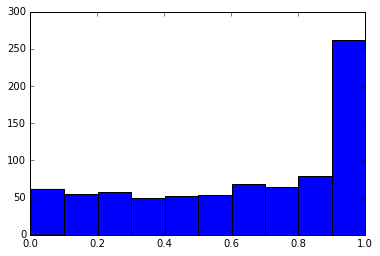

In [55]:
plt.hist(bad['purity'])

### how about repeated objects? 

In [8]:
seen = set()
duplic = set()
a = list(catalogue['db_id'])

for x in a:
    if x in seen: 
        duplic.add(x)
    if x not in seen:
        seen.add(x)
        
#get duplicated objects
l = []
for x in list(catalogue['db_id']):
    if x in duplic:
        l.append(True)
    else:
        l.append(False)
duplic_cat = catalogue[np.array(l)]

In [96]:
print len(duplic)
print len(seen)
print len (catalogue)
print 'duplicated objects are {0:.3g} of total objects'.format(float(len(duplic))/len(catalogue))

3904
857153
861061
duplicated objects are 0.00453 of total objects


In [16]:
duplic_cat.sort(['grp_id', 'db_id'])
duplic_cat

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit,bias_f,bias_s,bias_g1,bias_g2,bias_x,bias_y,bias_f_grp,bias_s_grp,bias_g1_grp,bias_g2_grp,bias_x_grp,bias_y_grp,match,ambig_blend
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bool
2200000555,2200000240,214,1,1,4361,4603,2756,3056,0.685356,0.314644,896.49,-1218.74,0.0846037,16.2328,0.42177,3.61558e+08,1.56803,1.78441,-0.344582,-0.0990926,2.28197,1.07745,-1.43079,1.71305,0.999973,25808.9,13395.5,13395.5,10456.4,9947.8,0.000127305,9.3756e-05,5.98466e-05,0.000133791,9.84812e-05,6.11835e-05,nan,nan,nan,0.0,2.98023e-09,1.60805,-9.13683e-09,-1.06858e-08,-3.07598e-09,-5.8437e-15,2.90509e-14,-3845.08,-1.27356e-05,-5.37742e-06,4.0166e-06,-4.22122e-06,4.1591e-06,-1,False
2200133472,2200000240,214,4,0,4472,4542,2778,2846,0.0341236,0.965876,901.44,-1237.5,0.841913,21.212,0.921425,3.6854e+06,0.718168,0.719633,0.0353748,-0.0280495,0.751356,0.686446,-0.335206,0.94706,0.930126,385.68,370.569,370.111,140.899,92.8762,0.013528,0.00703134,0.00702242,0.0186151,0.00745401,0.00739041,nan,nan,nan,-0.000201579,-0.000403345,111.188,4.95118e-06,2.07356e-06,-1.64453e-06,-1.89575e-10,-9.1206e-11,-369.62,-0.000349044,0.000164281,-0.000280067,2.05199e-05,-1.2707e-06,-1,False
2200176687,2200000240,214,9,0,4491,4543,2761,2859,0.887798,0.112202,903.525,-1237.86,1.22365,21.6915,0.146694,2.36964e+06,2.14054,2.46223,-0.325236,0.182552,3.16743,1.44657,1.31506,2.25263,0.597374,123.23,122.432,122.176,59.6073,45.5208,0.018067,0.0118822,0.0103924,0.021186,0.0139083,0.0110996,nan,nan,nan,0.0,2.98023e-09,582.381,6.36947e-05,-0.00010132,5.68974e-05,1.23659e-09,9.43483e-10,-561.055,-0.000546669,-0.000675405,-0.000188619,0.000137896,0.000141806,-1,False
2200418192,2200000240,214,6,0,4498,4529,3006,3030,1.0,0.0,902.829,-1196.29,0.418,22.3177,0.347864,1.33116e+06,0.407183,0.486704,0.411513,-0.0847523,0.637234,0.260184,-0.101556,0.770391,0.992564,201.132,196.729,196.707,129.294,129.279,0.0171324,0.0157278,0.0100623,0.0171344,0.0157296,0.0100634,nan,nan,nan,0.000450526,-0.000775929,81.9046,-0.000322996,0.000359622,-7.40703e-05,6.70732e-12,-1.10777e-11,81.3664,-0.000323697,0.000358983,-7.38023e-05,8.10165e-08,-1.48532e-08,-1,False
2201146821,2200000240,214,14,1,4474,4499,2839,2863,0.982529,0.0174709,897.438,-1229.7,0.743806,23.5378,0.887672,432709.0,0.589359,0.5899,0.0300565,0.00391684,0.607502,0.571758,0.0647929,0.853195,0.605723,53.8603,53.585,53.4733,32.8866,15.9387,0.0404889,0.0350374,0.0349654,0.0652371,0.0458225,0.0472989,nan,nan,nan,0.0145342,0.0121157,350.618,-0.00111057,0.000118709,1.52981e-05,4.16489e-08,-1.02934e-08,-7.5989,-0.00295925,0.000404165,0.000801905,0.000323369,-0.000245755,-1,False
2202263350,2200000240,214,40,0,4499,4518,2859,2880,0.332074,0.667926,901.795,-1226.04,1.26623,24.7199,1.29729,145655.0,0.450242,0.453709,-0.0672375,-0.0561138,0.491562,0.412396,-1.22307,0.764868,0.416668,20.1443,20.0944,20.0514,9.27937,8.84125,0.263867,0.174313,0.167814,0.279018,0.185892,0.171928,nan,nan,nan,0.0149556,-0.00250178,700.946,-0.0321266,-0.0205007,-0.0170899,1.32289e-07,-2.39431e-07,52.4563,-0.0464674,-0.0337146,-0.0210778,0.000846301,-6.67476e-05,-1,False
2202370755,2200000240,214,33,0,4491,4511,2751,2772,0.268081,0.731919,900.334,-1247.63,2.19791,24.6151,-0.045927,160423.0,0.355292,0.355996,-0.00519601,0.0441886,0.371467,0.33982,0.843923,0.71195,0.933425,24.4478,24.3668,24.3643,8.46094,6.24966,0.409123,0.199979,0.209556,0.529302,0.231632,0.

### example of duplicated galaxy

In [11]:
duplic_cat[duplic_cat['db_id'] == 2217027085]

db_id,grp_id,grp_size,grp_rank,visible,xmin,xmax,ymin,ymax,f_disk,f_bulge,dx,dy,z,ab_mag,ri_color,flux,sigma_m,sigma_p,e1,e2,a,b,beta,psf_sigm,purity,snr_sky,snr_iso,snr_grp,snr_isof,snr_grpf,ds,dg1,dg2,ds_grp,dg1_grp,dg2_grp,hsm_sigm,hsm_e1,hsm_e2,g1_fit,g2_fit,bias_f,bias_s,bias_g1,bias_g2,bias_x,bias_y,bias_f_grp,bias_s_grp,bias_g1_grp,bias_g2_grp,bias_x_grp,bias_y_grp,match,ambig_blend
int64,int64,int16,int16,int16,int32,int32,int32,int32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,int64,bool
2217027085,2217027085,1,0,1,2101,2108,4493,4500,1.0,0.0,1321.0,899.363,1.48348,27.9549,0.0440884,7401.95,0.219337,0.22021,0.00301493,-0.0629388,0.233622,0.205926,-0.761465,0.654762,1.0,1.37058,1.37032,1.37032,0.802957,0.802957,3.90224,3.49695,3.53842,3.90224,3.49695,3.53842,nan,nan,nan,0.0,0.0,23858.3,-16.1125,0.231926,-4.42353,-0.0248522,-0.0230392,23858.3,-16.1125,0.231926,-4.42353,-0.0248522,-0.0230392,-1,False
2217027085,2217027085,1,0,0,2101,2108,-7,0,1.0,0.0,1321.0,899.363,1.48348,27.9549,0.0440884,7401.95,0.219337,0.22021,0.00301493,-0.0629388,0.233622,0.205926,-0.761465,0.654762,1.0,1.37059,1.37032,1.37032,0.802982,0.802982,3.90214,3.49693,3.53827,3.90214,3.49693,3.53827,nan,nan,nan,0.0,0.0,23856.8,-16.1115,0.231886,-4.4234,-0.0241406,-0.0229965,23856.8,-16.1115,0.231886,-4.4234,-0.0241406,-0.0229965,194185,False


In [9]:
#obtain all non-duplicates and between duplicates choose the one that is matched or not ambiguously blended. 
def get_non_duplicated_cat(cat):
    #get non-duplicated and duplicated objects
    seen = set()
    duplic = set()
    a = list(catalogue['db_id'])

    for x in a:
        if x in seen: 
            duplic.add(x)
        if x not in seen:
            seen.add(x)

    #get duplicated objects
    duplic_bool = []
    non_duplic_bool = []
    for x in list(catalogue['db_id']):
        if x in duplic:
            duplic_bool.append(True)
            non_duplic_bool.append(False)
        else:
            duplic_bool.append(False)
            non_duplic_bool.append(True)
            
    duplic_cat = catalogue[np.array(duplic_bool)]
    non_duplic_cat = catalogue[np.array(non_duplic_bool)]  #decided to just remove duplicated 
    
    return non_duplic_cat
    
#     #add certain objects from the duplicated catalogue
#     #add row if it is a match or not ambiguously blended object.
    
#     selected_duplic_bool = []
    
#     #keep track of ids that were looked at with a dictionary to indicate a given id was already selected.
#     track = {} 
#     for row in duplic_cat:
#         if row['match'] != -1:
#             selected_duplic_bool.append(True)
#             track[row['db_id']] = 1
            
#         elif row['ambig_blend'] == False:
#             selected_duplic_bool.append(True)
#             track[row['db_id']] = 1
            
#         #otherwise just add whichever once we looked at both duplicated rows
#         if row['db_id'] not in track:
#             track[row['db_id']] = 0
#             selected_duplic_bool.append(False)
#         else:
#             selected_duplic_bool.append(True)
    
#     selected_duplics = duplic_cat[np.array(selected_duplic_bool)]

#     #now stack! 
#     #    return non_duplic_cat.S

In [10]:
c =get_non_duplicated_cat(catalogue)
c

In [16]:
print len(catalogue) - len(c)
print (len(catalogue) - len(set(catalogue['db_id'])))*2


7812
7816


In [ ]:

# conclude that have to eliminate both duplicated objects and rare_objs

In [18]:
print len(c)
print len(set(c['db_id'])) 

853249
853249


### check if these objects are in the border